# OBS!
#### Det är inte meningen att man ska köra alla celler rakt av. (Men dom kommer såklart i ordning.) 
Läs inledande kommentarer i cellerna, jag har lagt till nya kommentarer längst upp som är lite mer aktuella :)

In [5]:
import json
import glob
import os
import re
import pandas as pd
import numpy as np
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pathlib import Path
import datetime
import pprint
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.core.display import display, HTML

#gör notebooken större :) 
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None

In [81]:
#Här är koden som vi använde till att hitta alla filer med tweets i efter datainsamlingen och spara filvägarna. Går fort.


#Genererar ett filträd. Måste ligga i samma mapp som datamapparna
# tree[date][industry][company][handle] är en lista med alla filer för den användaren (alltså: mentions, till, från).  

#TESTAD 19/3, Patrik har kontrollerat att längden på fillistan stämmer överrens med antal jsonfiler och att filnamn
# inte förekommer dubbelt. Koden är testad när notebooken ligger i samma mapp som två datamappar (2020-03-18, 2020-03-19).

DEBUG = True
tree = {}
INDUSTRIES = ["Airlines"]

#Lista med alla mappar i working directory som heter något i stil med 1111-11-11
#    NYTT 13-April: la till datadir, eftersom allt beror på var du kör notebooken från. 
#    se output från os.getcwd() ovan för att lista ut vad datadir bör vara för dig.
datadir = "data"
collections = [d for d in glob.glob(os.path.join(datadir, "*")) if re.fullmatch(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', os.path.basename(d))]

for col in collections:
    tree[col] = {}
    for ind in INDUSTRIES:
        tree[col][ind] = {}
        
        #Den här fångar alla undermappar i /2020-xx-xx/<industry>/
        companies = [os.path.basename(x) for x in glob.glob(os.path.join(col, ind, "*"))]
        
        for comp in companies:
            tree[col][ind][comp] = {}
            
            #Traskar igenom "underfilträdet" för varje företag, alltså med /2020-xx-xx/industry/company/ som root. 
            #Lite snårig men finns bra dokumentation online.
            for root, dirs, files in os.walk(os.path.join(col, ind, comp), topdown=True):
                if dirs:
                    for handle in dirs:
                        tree[col][ind][comp][handle] = []
                else:
                    for f in files:
                        if f.find("tweet") == 0:
                            tree[col][ind][comp][os.path.basename(root)].append(os.path.join(root, f))
                            
#Printar en översikt av hela filträdet
if DEBUG:
    for c in tree.keys():
        print(c)
        for ind in tree[c].keys():
            print('\t', ind)
            for comp in tree[c][ind].keys():
                print('\t\t', comp)
                for handle in tree[c][ind][comp].keys():
                    print('\t\t\t', handle)
                    print('\t\t\t', "antal json:", str(len(tree[c][ind][comp][handle])))
                    for f in tree[c][ind][comp][handle]:
                        print('\t\t\t\t', f)

data/2020-03-18
	 Airlines
		 Aer Lingus
			 @AerLingus
			 antal json: 20
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_1.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_10.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_11.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_12.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_13.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_14.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_15.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_16.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_17.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_18.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_19.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_2.json
				 data/2020-03-18/Airlines/Aer Lingus/@AerLingus/tweet_list_20.json
				

			 @Alitalia
			 antal json: 2
				 data/2020-04-23/Airlines/Alitalia/@Alitalia/tweet_list_1.json
				 data/2020-04-23/Airlines/Alitalia/@Alitalia/tweet_list_2.json
		 British Airways
			 @British_Airways
			 antal json: 19
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_1.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_10.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_11.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_12.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_13.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_14.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_15.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_16.json
				 data/2020-04-23/Airlines/British Airways/@British_Airways/tweet_list_17.json
				 data/2020-04-23/Airlines/British 

In [ ]:
#Denna utgår frånn "tree" som vi genererat i cellen ovan och är till för att läsa jsonfiler och analysera sentiment. Tog 380 sek på min stationära. 
#Tyvärr är den lite gammal och jag har inte uppdaterat så att "created_at" fungerar med kod längre ned i notebooken, 
#  men om man sparar till csv första gången och sedan börjar därifrån varje gång funkar det. 


#Läser in allt i flera DataFrames och skriver ut hur lång tid det tog.
#ITEMS är de fält som tas med. Filtrerar direkt för att spara minne.
ITEMS = ["created_at", "full_text", "id", "metadata", "in_reply_to_status_id", "user", "retweeted_status", "in_reply_to_screen_name"]
ANALYZER = SentimentIntensityAnalyzer()

#Funktion som analyserar och returnerar sentimentet för en tweet
def analyze_sentiment(tweet_str):
    sentiment = ANALYZER.polarity_scores(tweet_str)
    return sentiment["compound"]



#dictionary för alla DataFrames
frames = {}

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
    companies = [company["name"] for company in json_list]
for company in companies:
    frames[company] = [] 
t_start = time.time()
for day in tree.keys():
    print(day)
    for company in tree[day]["Airlines"].keys():
        print("\t", company)
        for path in list(tree[day]["Airlines"][company].values())[0]:
            df = pd.read_json(path)
            #Ta bort alla fält som inte finns i items
            df = df.filter(items=ITEMS)
            #Ta bort retweets
            df = df[df["retweeted_status"].isnull()]
            #Skapa en bool-series baserat på språket och behåll endast kolumner där språket känns igen som engelska.
            en = df.metadata.apply(lambda x: x["iso_language_code"] == "en")
            df = df[en]
            #Plocka ut id och screen name från user, de får egna kolumner
            df["user.id"] = df.user.apply(lambda x: x["id"])
            df["user.screen_name"] = df.user.apply(lambda x: x["screen_name"])
            #Lägg till kolumner som anger vilket företag tweeten insamlats från (alltså EJ avsändaren), samt insamlingsdatum
            df["associated_company"]=company
            df["collection_date"]=day
            #Ta bort kolumner vi inte använder
            df = df.drop(["metadata", "user", "retweeted_status"], axis=1)
            df["sentiment"] = df.full_text.apply(lambda x: analyze_sentiment(x))
            #Lägg till i dictionaryt
            frames[company].append(df)
            
            
    
print("Time - read&analyze files:", time.time()-t_start, "seconds")



In [ ]:
# För att det vi fått ut i cellen ovan ska vara användbart behöver denna köras, så de hör ihop. 

#Styr upp all inläst data.
#Slår ihop alla listor i frames så att varje företag får en egen DataFrame. 
# -Alla tweets i ett företags sammanslagna DataFrame är unika. 
# -Samma tweet kan förekomma i två olika företags DataFrames 
#       (om de tex har taggat flera företag eller svarat ett företag och taggat ett annat)
#Skapar även en DataFrame all_data där alla DataFrames från olika företag slås ihop
# -Alla tweets i all_data är unika.
# -Kolumnen "associated_company" i all_data är alltså oren eftersom tweets som taggar flera företag här endast
#    tillhör det företag som programmet såg först.

#DUPLICATES SYFTAR ALLTSÅ PÅ ATT TWEETS SOM TAGGAR FLERA FÖRETAG RÄKNAS DUBBELT, INTE ATT DE SAMLATS IN DUBBELT

#totala antalet tweets i dictionaryt frames
total_dup = 0
#totala minnesanvändningen för frames + all_data
total_memory = 0
all_data = []
for company in companies:
    #slår ihop alla DataFrames för ett företag till en enda och tar bort dubbelinsamlade tweets för det företaget.
    frames[company] = pd.concat(frames[company])
    frames[company] = frames[company].drop_duplicates(subset="id")
    #Lägger till den framen till all_data
    all_data.append(frames[company])
    
    total_dup += frames[company].shape[0]
    mem = frames[company].memory_usage(index=True, deep=True).sum() / 1000000
    total_memory += mem
    #Skriver ut antalet unika tweets för varje företag och hur mycket minne som går åt (mest för kontroll)
    print(company, "- tweets:", frames[company].shape[0], "- memory:", mem)
#Slår ihop all_data till en frame och tar bort duplicates
all_data = pd.concat(all_data)
all_data = all_data.drop_duplicates(subset="id")
mem = all_data.memory_usage(index=True, deep=True).sum() / 1000000
total_memory+=mem
#Skriver ut totala antalet unika tweets och hur mycket minne all_data tar
print("all_data - tweets:", all_data.shape[0], "-memory:", mem)
#Skriver ut summan av antalet tweets för varje företag, samt totala minnesanvändningen (frames + all_data)
#Se ovan exakt vad som menas med duplicates.
print("total (with duplicates) - tweets:", total_dup, "- memory:", total_memory)

In [85]:
# Den här känner du säkert igen Siri :)

#Spara till csv
Path("csv").mkdir(exist_ok=True)
for company in companies:
    frames[company].to_csv(os.path.join("csv", company+".csv"), index=False)
all_data.to_csv(os.path.join("csv", "all_data.csv"), index=False)
with open("csv/dates.txt", "w") as f:
    for day in tree.keys():
        f.write(day+"\n")


# Börja här om du har en csvfil som sparats med koden ovan

In [11]:
# Öppnar från csv och ser till att "created_at" har rätt format, timezone är korrigerat för (snarare borttaget eftersom alla var samma)

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
    companies = [company["name"] for company in json_list]
frames = {}
all_data = None
for company in companies:
    frames[company] = pd.read_csv(os.path.join("csv", company+".csv"), index_col="id")
    frames[company]["created_at"] = pd.to_datetime(frames[company]["created_at"], errors="coerce")
    frames[company]["created_at"] = frames[company]["created_at"].dt.tz_convert(None)
all_data = pd.read_csv(os.path.join("csv", "all_data.csv"), index_col="id")
all_data["created_at"] = pd.to_datetime(all_data["created_at"], errors="coerce")
all_data["created_at"] = all_data["created_at"].dt.tz_convert(None)

# Och vår Hello World plot såklart:
all_data["created_at"].dt.to_period("D").value_counts().sort_index().plot(kind="bar")
plt.show()

In [5]:
#Lite gamla grejer, lämnade det som referens ifall vi vill få ut liknande senare. 

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
    handles = [company["twitter_handle"] for company in json_list]
starters = all_data[all_data["in_reply_to_status_id"].isnull()]
company_starters = starters[starters["user.screen_name"].isin(handles)]
responders = all_data[all_data["in_reply_to_status_id"].notnull()]
company_responders = responders[responders["user.screen_name"].isin(handles)]
print("alla tweets:", all_data.shape[0])
print("antal initiala tweets:", starters.shape[0])
print("företagen twittrar först:", company_starters.shape[0])
print("antal svar (måste inte svara på tweets som vi samlat in):", responders.shape[0])
print("antal företagssvar (måste inte svara på tweets som vi samlat in):", company_responders.shape[0])

alla tweets: 435145
antal initiala tweets: 156440
företagen twittrar först: 1109
antal svar (måste inte svara på tweets som vi samlat in): 278705
antal företagssvar (måste inte svara på tweets som vi samlat in): 56504


In [168]:
#Dags att definiera lite funktioner

#Den hör borde väl vara rätt lik den du skrev Siri
def build_threads(all_tweets, initial_tweets):
    subthreads = {}
    for index, row in initial_tweets.iterrows():
        subthreads[index] = {
            "screen_name": row["user.screen_name"], 
            "sentiment": row["sentiment"], 
            "created_at": row["created_at"],
            #"full_text": row["full_text"], # Om vi behöver
            "responses": None
        }
        responses = all_tweets[all_tweets["in_reply_to_status_id"] == index]
        if not responses.empty:
            subthreads[index]["responses"] = build_threads(all_tweets, responses)
    return subthreads


# Dessa två nedan är för att göra om dictionaryt från funktionen ovan till linked lists,
#    jag tyckte det blev enklare för att identifiera konversationerna. Klassen nod är varje
#    nod i en linked list. Dessa behöver såklart inte användas, men jag har kod som använder 
#    dem redan. 
class Node:
    def __init__(self, _id=None, data=None):
        if data is None:
            self.screen_name = None
            self.created_at = None
            self.sentiment = None
            #self.full_text = None # Dessa utkommenterade funkar bara om full_text finns i subthreads från ovan. 
        else: 
            self.screen_name = data["screen_name"]
            self.created_at = data["created_at"]
            self.sentiment = data["sentiment"]
            #self.full_text = data["full_text"]
        self.id = _id
        self.next=None
        self.prev=None

# Konceptet är att varje "steg" i subthreads har ett antal responses, och denna går rekursivt ned i det "trädet"
#   för att skapa en linked list per gren. (En gren går från toppen tills den tar slut.) Huvudnoden i varje 
#   linked list sparas i head. Har försökt rita ett exempel nedan:
#
#  subthreads = {
#                  3
#                 /      
#               2     
#             /  \ 
#     id:1  1     4 - 5
#            \
#             6
#     ,,,
#             8
#            /
#     id:7  7 - 9
# }
#
# heads = [(1->2->3), (1->2->4->5), (1->6), (7->8), (7->9)]   
# OBS! ej tuples, endast illustration av linked lists.
#
def create_llists(threads_dic):
    heads = []
    for k, v in threads_dic.items():
        if v["responses"] is not None:
            children = create_llists(v["responses"])
            for child in children:
                this = Node(k, v)
                child.prev = this
                this.next = child
                heads.append(this)
        else:
            heads.append(Node(k, v))
    return heads

In [ ]:
# Använde detta för att testa koden ovan. Tror inte den är så relevant.

#Lite proof-of-concept för att bygga konversationsträd där den första tweeten svarar på en extern tweet.     

test = frames["Aeroflot Group"]
print("testantal:", test.shape[0])
test = test.filter(items=["created_at", "in_reply_to_status_id", "user.screen_name", "sentiment", "full_text"])
initial = test[test["in_reply_to_status_id"].isnull()]
responses = test[test["in_reply_to_status_id"].notnull()]
responding_to_external = responses[~responses["in_reply_to_status_id"].isin(test.index)]
conversation_starters = build_threads(test, initial)
conversation_continue = build_threads(test, responding_to_external)

print("antal initiala tweets:", initial.shape[0])
print("antal svar:", responses.shape[0])
print("antal svar på externa tweets:", responding_to_external.shape[0])
print("interna konversationer:", len([x for x in conversation_starters.values() if x["responses"] is not None]))
print("'importerade' konversationer:", len([x for x in conversation_continue.values() if x["responses"] is not None]))

internal = []
external = []

def recursive_idfinder(responses):
    ids = []
    if responses is not None:
        for k, v in responses.items():
            ids.append(k)
            ids += recursive_idfinder(v["responses"])
    return ids

for _id, tweet in conversation_starters.items():
    internal.append(_id)
    internal += recursive_idfinder(tweet["responses"])

for _id, tweet in conversation_continue.items():
    external.append(_id)
    external += recursive_idfinder(tweet["responses"])

print("\nLite testutskrifter för att se att samma tweets inte hamnar i båda konversationssamlingarna:")
print(len(internal))
print(len(set(internal)))
print(len(external))
print(len(set(external)))

for _id in internal:
    if _id in external:
        print("aj")
print("\nDubbelförsäkran: antal konversationer i de båda samlingarna innan ihopslagning...")
start_count = len(conversation_starters.keys())
continue_count = len(conversation_continue.keys())
print(start_count, "+", continue_count, "=", start_count+continue_count)
print("...och efter ihopslagning")
conversation_starters.update(conversation_continue)
conversations = conversation_starters
print(len(conversations.keys()))

In [31]:
# Såhär kan man köra dom, men gammal kod.

conversations = {}
for company in frames.keys():
    company_df = frames[company]
    company_df = company_df.filter(items=["in_reply_to_status_id", "user.screen_name", "sentiment", "created_at"])
    initial = company_df[company_df["in_reply_to_status_id"].isnull()]
    conversations[company] = build_threads(company_df, initial)
    
linked_lists = {}
for company in conversations.keys():
    linked_lists[company] = create_llists(conversations[company])

In [ ]:
# Tror att detta funkar för att hitta trådstartare -> företagssvar -> trådstartare, men jobbar på det längre ned.
# Cellerna under denna innehåller andra försök som jag tror inte blev så bra, men har sparat dem så länge. 

test = "British Airways"
print(len(linked_lists[test]))
results = {}
for comp in json_list:
    name = comp["name"]
    handle = comp ["twitter_handle"]
    results[name] = {}
    results[name]["sentiment_changes"] = []
    results[name]["starter_responses_sentiment"] = []
    results[name]["answer_times"] = []
    
    prev_head = Node(_id=-1)
    for conv_head in linked_lists[name]:
        if prev_head.id != conv_head.id:
            answer_found = False
            prev_head = conv_head
        if not answer_found:
            if conv_head.screen_name != handle:
                if conv_head.next is not None and conv_head.next.next is not None:
                    if conv_head.next.screen_name == handle:
                        c_response = conv_head.next
                        if c_response.next.screen_name == conv_head.screen_name:
                            answer_found = True
                            results[name]["sentiment_changes"].append(c_response.next.sentiment - conv_head.sentiment)
                            results[name]["starter_responses_sentiment"].append(c_response.next.sentiment)
                            results[name]["answer_times"].append(c_response.created_at - conv_head.created_at)
                            

In [50]:
# Tror denna testar den ovan, men minns inte riktigt. 
for comp in json_list:
    name = comp["name"]
    handle = comp["twitter_handle"]
    comp_collection = frames[name]
    company_tweets = comp_collection[comp_collection["user.screen_name"] == handle]
    
    print(comp_collection.shape[0], company_tweets.shape[0])
    company_responses = company_tweets[~company_tweets["in_reply_to_status_id"].isnull()]
    
    print(name, len(results[name]["sentiment_changes"]), company_responses.shape[0])

16904 3405
Lufthansa Group 759 3387
7416 1058
Air France-KLM 161 1051
109164 20581
British Airways 3330 20564
4782 0
Iberia 0 0
33584 5077
Aer Lingus 1023 5046
4836 1104
Vueling Airlines 186 1104
82245 2981
Ryanair 675 2965
1368 293
Aeroflot Group 48 293
7373 33
Turkish Airlines 0 1
110969 11083
easyJet 1982 10371
4604 1312
SAS Group 270 1256
11411 2458
Norwegian Air 284 2446
8513 1287
TAP Air Portugal 149 1274
2993 583
Alitalia 94 580
35857 5961
Jet2.com 897 5844
792 17
Pegasus Airlines 0 7
896 0
Flybe 0 0
2618 360
Finnair 21 295


In [26]:
# Tror denna dubbelräknar? 
company_sent_changes = {}
for comp in json_list:
    name = comp["name"]
    company_sent_changes[name] = []
    handle = comp ["twitter_handle"]
    for conv_head in linked_lists[name]:
        this = conv_head
        first_company_response = None
        while this.next is not None:
            this = this.next
            if this.screen_name == handle:
                first_company_response = this
                break
        if first_company_response is not None:
            prev_tweets = []
            this = first_company_response
            while this.prev is not None:
                this = this.prev
                if (this.screen_name not in [tweet.screen_name for tweet in prev_tweets]) and this.screen_name != handle:
                    prev_tweets.append(this)
            this = first_company_response
            answer_found = False
            while (this.next is not None) and not answer_found:
                this = this.next
                for prev in prev_tweets: 
                    if this.screen_name == prev.screen_name:
                        company_sent_changes[name].append(this.sentiment - prev.sentiment)
                        answer_found = True
                        break
            
            

In [25]:
# Den här tror jag är rätt dålig, framförallt jobbig att läsa haha. 
conversations = {}
for company in frames.keys():
    company_df = frames[company]
    company_df = company_df.filter(items=["in_reply_to_status_id", "user.screen_name", "sentiment"])
    initial = company_df[company_df["in_reply_to_status_id"].isnull()]
    responses = company_df[company_df["in_reply_to_status_id"].notnull()]
    continuing = responses[~responses["in_reply_to_status_id"].isin(company_df.index)]
    conversations[company] = build_threads(company_df, initial)
    conversations[company].update(build_threads(company_df, continuing))

linked_lists = {}
for company in conversations.keys():
    linked_lists[company] = create_llists(conversations[company])
    
company_sent_changes = {}
for comp in json_list:
    name = comp["name"]
    company_sent_changes[name] = []
    handle = comp ["twitter_handle"]
    for conv_head in linked_lists[name]:
        this = conv_head
        if this.screen_name != handle:
            starter = conv_head
            company_response = False
            while this.next is not None:
                this = this.next
                if this.screen_name == handle:
                    company_response = True
                    break
            if company_response:
                while this.next is not None:
                    this = this.next
                    if this.screen_name == starter.screen_name:
                        
            if first_company_response is not None:
                prev_tweets = []
                this = first_company_response
                while this.prev is not None:
                    this = this.prev
                    if (this.screen_name not in [tweet.screen_name for tweet in prev_tweets]) and this.screen_name != handle:
                        prev_tweets.append(this)
                this = first_company_response
                answer_found = False
                while (this.next is not None) and not answer_found:
                    this = this.next
                    for prev in prev_tweets: 
                        if this.screen_name == prev.screen_name:
                            company_sent_changes[name].append(prev.sentiment - this.sentiment)
                            answer_found = True
                            break

2618

In [ ]:
# Från när jag läste 75 tweets/företag. kör inte. 

Path("sample").mkdir(exist_ok=True)
strptime = datetime.datetime.strptime
dates = [datetime.date(2020, 3, 25), datetime.date(2020, 4, 9)]
with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
for comp in json_list:
    name = comp["name"]
    handle = comp["twitter_handle"]
    tweets = frames[name]
    comp_tweets = tweets[tweets["user.screen_name"]==handle]
    comp_replys = comp_tweets[comp_tweets["in_reply_to_status_id"].notnull()]
    early = comp_replys[comp_replys["created_at"].dt.date <= dates[0]]
    mid = comp_replys[comp_replys["created_at"].dt.date > dates[0] ]
    mid = mid[mid["created_at"].dt.date <= dates[1]]
    late = comp_replys[comp_replys["created_at"].dt.date > dates[1]]
    
    with open(os.path.join("sample", name+".txt"), "w") as f:
        
        print(name)
        for period in [(early, "early"), (mid, "mid"), (late, "late")]:
            count = period[0].shape[0]
            print(period[1], count)
            f.write("\n"+period[1]+"\n")
            if count < 25:
                sample = period[0].sample(n=count, axis=0)["full_text"]
            else:
                sample = period[0].sample(n=25, axis=0)["full_text"]
            for text in sample:
                f.write("\n***\n"+text+"\n")


In [45]:
# Från nyligen, 900/3 tweets per företag till excel. Kör inte. 

Path("lasning").mkdir(exist_ok=True)
strptime = datetime.datetime.strptime

dates = [datetime.date(2020, 3, 25), datetime.date(2020, 4, 9)]
ursakter = ["ta_ansvar", "ge_forklaring", "ge_rad", "visa_anger", "beratta_hur_vardefulla_anvandarna_ar", "visa_intresse_for_varderingar", "sympatisera_med_lidande", "beratta_om_arbete_for_skadebegransning", "erbjud_ersattning", "kommunikation_via_person", "lamplig_halsning", "bjud_in_till_ytterligare_kontakt"]


selected = ["easyJet", "Ryanair", "Aer Lingus", "British Airways"]
with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
selected_list = [x for x in json_list if x["name"] in selected]

for comp in selected_list:
    name = comp["name"]
    handle = comp["twitter_handle"]
    tweets = frames[name]
    comp_tweets = tweets[tweets["user.screen_name"]==handle]
    comp_replys = comp_tweets[comp_tweets["in_reply_to_status_id"].notnull()]
    
    early = comp_replys[comp_replys["created_at"].dt.date < dates[0]]
    mid = comp_replys[comp_replys["created_at"].dt.date >= dates[0] ]
    mid = mid[mid["created_at"].dt.date < dates[1]]
    late = comp_replys[comp_replys["created_at"].dt.date >= dates[1]]
    
    for period in [(early, "early"), (mid, "mid"), (late, "late")]:
        to_code = period[0].drop(axis=1, columns=["created_at", "in_reply_to_status_id", "in_reply_to_screen_name", "user.id", "user.screen_name", "associated_company", "collection_date", "sentiment"])
        for urs in ursakter:
            to_code[urs] = ""
        to_code = to_code.sample(n=300, axis=0)
        to_code = to_code.reset_index()
        to_code["id"] = to_code["id"].astype(str)
        to_code.to_excel("lasning/"+name+"_"+period[1]+".xlsx", index_label="index")

# Det jag använt till preliminära resultat-dokumentet

In [132]:
# Lite funktioner för det vi presenterade för Peter som preliminära resultat nyligen. 
def calc_reply_times(comp_replys, from_users):
    reply_times = {}
    for index, row in comp_replys.iterrows():
        initial_tweet_id = int(row["in_reply_to_status_id"])
        try:
            initial_tweet = from_users.loc[initial_tweet_id]
            
            date = initial_tweet["created_at"].date()
            if str(date) not in reply_times.keys():
                reply_times[str(date)] = []
                
            reply_times[str(date)].append(row["created_at"] - initial_tweet["created_at"])
            
        except KeyError:
            pass
    return reply_times
def calc_sentiment_perday(from_users):
    sentiments = {}
    for index, row in from_users.iterrows():
        date = row["created_at"].date()
        if str(date) not in sentiments.keys():
                sentiments[str(date)] = []
        sentiments[str(date)].append(row["sentiment"])
    for date in sentiments.keys():
        sentiments[date] = np.mean(sentiments[date])
    return sentiments

In [9]:
#Tittar på lite medelvärden för de olika perioderna. Kanske finns något värt exempel här, men har inte använt till något. 


selected = ["easyJet", "Ryanair", "Aer Lingus", "British Airways"]
dates = [datetime.date(2020, 3, 25), datetime.date(2020, 4, 9)]
#perioderna är före 25e, mellan 25-8, från 9:e.

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
selected_list = [x for x in json_list if x["name"] in selected]

for comp in selected_list:
    name = comp["name"]
    handle = comp["twitter_handle"]
    all_tweets = frames[name]
    
    early = all_tweets[all_tweets["created_at"].dt.date < dates[0]]
    mid = all_tweets[all_tweets["created_at"].dt.date >= dates[0] ]
    mid = mid[mid["created_at"].dt.date < dates[1]]
    late = all_tweets[all_tweets["created_at"].dt.date >= dates[1]]
    
    tweets = {}
    print(name)
    for period, period_str in [(early, "early"), (mid, "mid"), (late, "late")]:
        tweets[period_str] = {}
        from_comp = period[period["user.screen_name"] == handle]
        comp_replys = from_comp[from_comp["in_reply_to_status_id"].notnull()]
        from_user = period[period["user.screen_name"] != handle]
        
        mean_time_perday = [np.mean(x) for x in calc_reply_times(comp_replys, from_user).values()]
        mean_reply_time = np.mean(mean_time_perday)
        print(period_str)
        print(mean_reply_time)
        print(round(comp_replys.shape[0]/from_user.shape[0], 2))
        print(from_user["sentiment"].mean())
        
        

British Airways
early
1 days 16:55:53.112850
0.19
0.10031578812751413
mid
1 days 15:35:25.327789
0.27
0.1261026763630994
late
1 days 11:01:14.649030
0.28
0.1280922702439552
Aer Lingus
early
0 days 08:42:52.816707
0.16
0.053050113004703435
mid
0 days 03:19:09.081626
0.16
0.2105854256854257
late
0 days 01:10:37.317911
0.34
0.09244944035817078
Ryanair
early
0 days 19:48:32.391463
0.02
0.02373100040520463
mid
1 days 09:31:16.489514
0.13
0.06201455969746083
late
1 days 21:23:41.021136
0.04
0.018671236970624682
easyJet
early
0 days 22:05:45.150933
0.06
0.07455073018458197
mid
1 days 02:21:41.523079
0.07
0.07694453005327054
late
1 days 02:00:23.971956
0.26
0.1074519138136427


In [136]:
# Styr upp en dataframe per företag med genomsnittlig svarstid, sentiment och frekvens per dag.
# Detta användes sedan till figurerna och tabellerna som vi skickade till Peter som preliminära resultat.

selected = ["easyJet", "Ryanair", "Aer Lingus", "British Airways"]
dates = [datetime.date(2020, 3, 25), datetime.date(2020, 4, 9)]
#perioderna är före 25e, mellan 25-8, från 9:e.

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
selected_list = [x for x in json_list if x["name"] in selected]

results = {}
for comp in selected_list:
    name = comp["name"]
    handle = comp["twitter_handle"]
    all_tweets = frames[name]
    from_comp = all_tweets[all_tweets["user.screen_name"] == handle]
    comp_replys = from_comp[from_comp["in_reply_to_status_id"].notnull()]
    from_user = all_tweets[all_tweets["user.screen_name"] != handle]
    
    reply_times = calc_reply_times(comp_replys, from_user)
    for date in reply_times.keys():
        reply_times[date] = np.mean(reply_times[date])
        
    
    df = pd.DataFrame.from_dict(data=reply_times, orient="index", columns=["avg_reply_time_minutes"]).sort_index()
    df["avg_reply_time_minutes"] = df["avg_reply_time_minutes"].apply(lambda x: x.seconds/60)
    
    from_comp_perday = from_comp["created_at"].dt.to_period("D").value_counts().sort_index()
    from_user_perday = from_user["created_at"].dt.to_period("D").value_counts().sort_index()
    reply_freq = from_comp_perday / from_user_perday
    reply_freq.index = pd.Index(reply_freq.index, dtype="O")
    
    df = df.set_index(reply_freq.index)
    df["reply_freq"] = reply_freq
    
    sentiment_perday = pd.Series(calc_sentiment_perday(from_user)).sort_index()
    df = df.set_index(sentiment_perday.index)
    df["avg_sentiment"] = sentiment_perday
    
    results[name] = df
    



British Airways


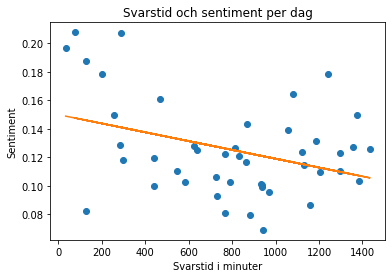

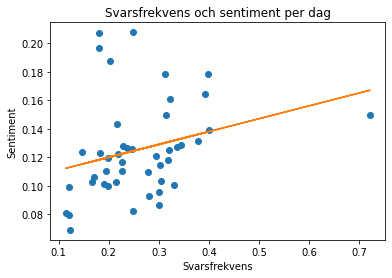

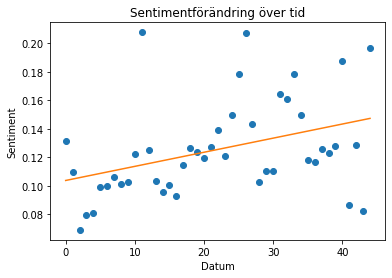

correlation matrix:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,1.00000,0.21871,-0.36365,-0.23157
reply_freq,0.21871,1.00000,0.27907,0.26870
avg_sentiment,-0.36365,0.27907,1.00000,0.38391
day,-0.23157,0.26870,0.38391,1.00000


p-values:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,0.00000,0.14890,0.01407,0.12586
reply_freq,0.14890,0.00000,0.06339,0.07430
avg_sentiment,0.01407,0.06339,0.00000,0.00923
day,0.12586,0.07430,0.00923,0.00000




Aer Lingus


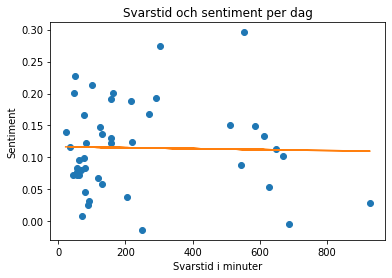

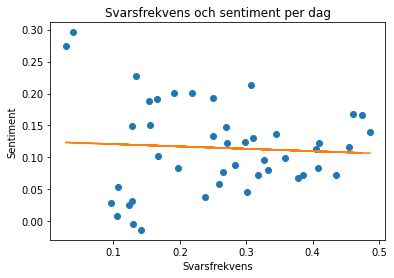

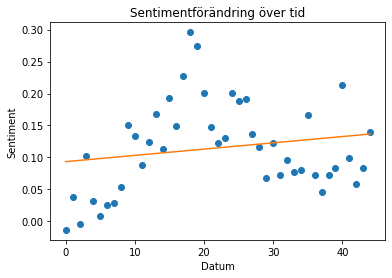

correlation matrix:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,1.00000,-0.44415,-0.02449,-0.61580
reply_freq,-0.44415,1.00000,-0.06390,0.59200
avg_sentiment,-0.02449,-0.06390,1.00000,0.18261
day,-0.61580,0.59200,0.18261,1.00000


p-values:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,0.00000,0.00224,0.87312,0.00001
reply_freq,0.00224,0.00000,0.67666,0.00002
avg_sentiment,0.87312,0.67666,0.00000,0.22989
day,0.00001,0.00002,0.22989,0.00000




Ryanair


/home/banan1994/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


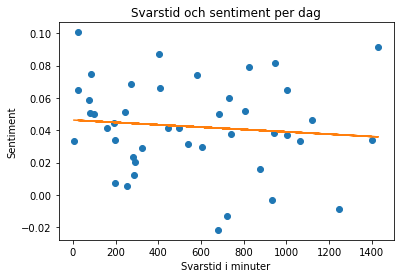

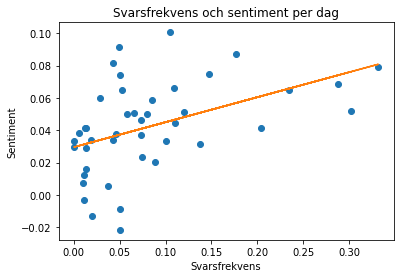

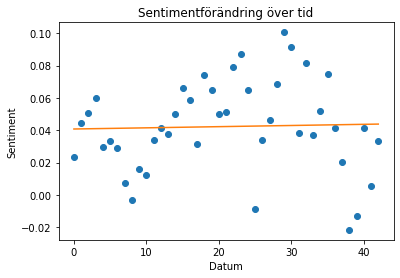

correlation matrix:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,1.00000,-0.25352,-0.10213,-0.02377
reply_freq,-0.25352,1.00000,0.45203,0.28427
avg_sentiment,-0.10213,0.45203,1.00000,0.03208
day,-0.02377,0.28427,0.03208,1.00000


p-values:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,0.00000,0.10093,0.51459,0.87975
reply_freq,0.10093,0.00000,0.00234,0.06468
avg_sentiment,0.51459,0.00234,0.00000,0.83818
day,0.87975,0.06468,0.83818,0.00000




easyJet


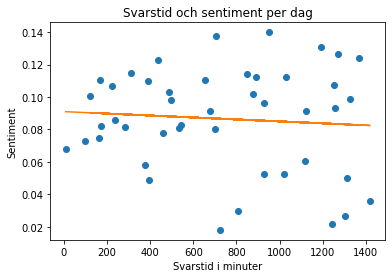

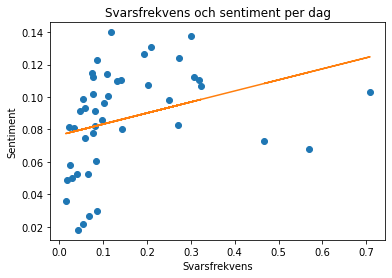

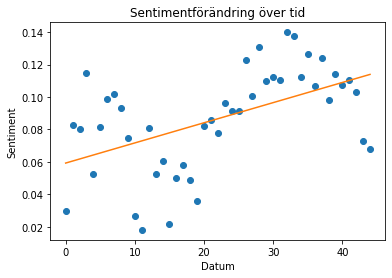

correlation matrix:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,1.00000,-0.30591,-0.07976,-0.15377
reply_freq,-0.30591,1.00000,0.32118,0.65398
avg_sentiment,-0.07976,0.32118,1.00000,0.51583
day,-0.15377,0.65398,0.51583,1.00000


p-values:


,avg_reply_time_minutes,reply_freq,avg_sentiment,day
avg_reply_time_minutes,0.00000,0.04099,0.60251,0.31322
reply_freq,0.04099,0.00000,0.03145,0.00000
avg_sentiment,0.60251,0.03145,0.00000,0.00029
day,0.31322,0.00000,0.00029,0.00000


In [190]:
#Gör figurer och tabeller. OBS! SPARAR ÄVEN FIGURERNA :) 

Path("figurer").mkdir(exist_ok=True)

df_corr = pd.DataFrame()
df_p = pd.DataFrame()
for name, _df in results.items():
    df = _df.dropna()
    df["day"] = np.arange(0, df.shape[0])
    
    print("\n\n"+name)
    
    fig = plt.figure()
    x = df["avg_reply_time_minutes"]
    y = df["avg_sentiment"]
    plt.plot(x, y, 'o')
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.xlabel("Svarstid i minuter")
    plt.ylabel("Sentiment")
    plt.title("Svarstid och sentiment per dag")
    plt.show()
    fig.savefig("figurer/svarstid_"+name+".png")
    
    
    fig = plt.figure()
    x = df["reply_freq"]
    y = df["avg_sentiment"]
    plt.plot(x, y, 'o')
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.xlabel("Svarsfrekvens")
    plt.ylabel("Sentiment")
    plt.title("Svarsfrekvens och sentiment per dag")
    plt.show()
    fig.savefig("figurer/svarsfrekvens_"+name+".png")
    
    fig = plt.figure()
    x = df["day"]
    y = df["avg_sentiment"]
    plt.plot(x, y, 'o')
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.xlabel("Datum")
    plt.ylabel("Sentiment")
    plt.title("Sentimentförändring över tid")
    plt.show()
    fig.savefig("figurer/tidsförändring_"+name+".png")
    
    for x in df.columns:
        for y in df.columns:
            corr = np.round(stats.pearsonr(df[x], df[y]), 5)
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    print("correlation matrix:")
    display(df_corr)
    print("p-values:")
    display(df_p)

In [171]:
# ... och här är jag nu, tittar på konversationerna. Det borde funka men jag hann inte göra något med det
#     innan vi skickade preliminära resultat till Peter.

selected = ["easyJet", "Ryanair", "Aer Lingus", "British Airways"]
dates = [datetime.date(2020, 3, 25), datetime.date(2020, 4, 9)]
#perioderna är före 25e, mellan 25-8, från 9:e.

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
selected_list = [x for x in json_list if x["name"] in selected]

conv_results = {}
for comp in selected_list:
    name = comp["name"]
    handle = comp["twitter_handle"]
    conv_results[name] = {}
    
    all_tweets = frames[name]
    
    early = all_tweets[all_tweets["created_at"].dt.date < dates[0]]
    mid = all_tweets[all_tweets["created_at"].dt.date >= dates[0] ]
    mid = mid[mid["created_at"].dt.date < dates[1]]
    late = all_tweets[all_tweets["created_at"].dt.date >= dates[1]]
    
    for df, period in [(early, "early"), (mid, "mid"), (late, "late")]:
        print(name, period)
        
        conv_results[name][period] = []
        
        initial = df[df["in_reply_to_status_id"].isnull()]
        threads = build_threads(df, initial)
        l_list = create_llists(threads)
        prev_head = Node(_id=-1)
        for conv_head in l_list:
            if prev_head.id != conv_head.id:
                answer_found = False
                prev_head = conv_head
            if not answer_found:
                if conv_head.screen_name != handle:
                    if conv_head.next is not None and conv_head.next.next is not None:
                        if conv_head.next.screen_name == handle:
                            c_response = conv_head.next
                            if c_response.next.screen_name == conv_head.screen_name:
                                answer_found = True
                                conv_results[name][period].append({
                                    "sentiment_change": c_response.next.sentiment - conv_head.sentiment,
                                    "answer_time": c_response.created_at - conv_head.created_at
                                })
        

British Airways early
British Airways mid
British Airways late
Aer Lingus early
Aer Lingus mid
Aer Lingus late
Ryanair early
Ryanair mid
Ryanair late
easyJet early
easyJet mid
easyJet late


In [9]:
# När jag la till nollor som saknades. Lämnar den här längst ned som ett exempel om vi vill ha det till något...
ursakter = ["ta_ansvar", "ge_forklaring", "ge_rad", "visa_anger", "beratta_hur_vardefulla_anvandarna_ar", "visa_intresse_for_varderingar", "sympatisera_med_lidande", "beratta_om_arbete_for_skadebegransning", "erbjud_ersattning", "kommunikation_via_person", "lamplig_halsning", "bjud_in_till_ytterligare_kontakt", "ge_info", "svar_klagomal"]
Path("nollor").mkdir(exist_ok=True)
for path in glob.glob("patrik_early_late/*"):
    print(path)
    df = pd.read_excel(path, index_col="index")
    df = df.fillna(0)
    for urs in ursakter:
        df[urs] = df[urs].astype(int)
    df["id"] = df["id"].astype(str)
    df.to_excel("nollor/"+os.path.basename(path), index_label="index")


patrik_early_late/Aer Lingus_early_klar.xlsx
patrik_early_late/Aer Lingus_late_klar.xlsx
patrik_early_late/British Airways_early_klar.xlsx
patrik_early_late/British Airways_late_klar.xlsx
patrik_early_late/Ryanair_early_klar.xlsx
patrik_early_late/Ryanair_late_klar.xlsx
patrik_early_late/easyJet_early_klar.xlsx
patrik_early_late/easyJet_late_klar.xlsx
